In [9]:
# Cell 1: Imports and setup
import os
import re
import nltk
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import numpy as np
import faiss
import matplotlib.pyplot as plt
import fitz 
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/anniii/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
pdf_path = "/Users/anniii/Desktop/assignment_woundrsight/data/9241544228_eng.pdf"
output_folder = "/Users/anniii/Desktop/assignment_woundrsight/data"  
output_txt = os.path.join(output_folder, "output.txt")

doc = fitz.open(pdf_path)
text = ""

for page in doc:
    text += page.get_text()

with open(output_txt, "w", encoding="utf-8") as f:
    f.write(text)

print(f"PDF content saved to {output_txt}")

PDF content saved to /Users/anniii/Desktop/assignment_woundrsight/data/output.txt


In [17]:
# Cell 2: Load your provided document
data_path = "../data/output.txt"
assert os.path.exists(data_path), "Your document file does not exist."

with open(data_path, 'r', encoding='utf-8') as f:
    raw_text = f.read()

print("First 500 chars of raw text:")
print(raw_text[:500])

First 500 chars of raw text:
ThelCD-10
Classification
of Mental and
Behavioural
Disorders
Clinical
descriptions
and diagnostic
guidelines
| 
World Health Organization
I 
Geneva
I 
1992
ICD-10
Reprinted 1993, 1994, 1995, 1998, 2000, 2002, 2004
WHO Library Cataloguing in Publication Data
The ICD-10 classification of mental and behavioural
disorders : clinical descriptions and diagnostic guidelines.
1.Mental disorders — classification 
2.Mental disorders — diagnosis
ISBN 92 4 154422 8 
(NLM Classification: WM 15)
© World Healt


In [18]:
# Cell 3: Clean and normalize text
def clean_text(text):
    text = re.sub(r'\n+', '\n', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\f', '', text)
    text = re.sub(r'Page \\d+', '', text)
    return text.strip()

cleaned_text = clean_text(raw_text)
print("First 500 chars of cleaned text:")
print(cleaned_text[:500])

First 500 chars of cleaned text:
ThelCD-10 Classification of Mental and Behavioural Disorders Clinical descriptions and diagnostic guidelines | World Health Organization I Geneva I 1992 ICD-10 Reprinted 1993, 1994, 1995, 1998, 2000, 2002, 2004 WHO Library Cataloguing in Publication Data The ICD-10 classification of mental and behavioural disorders : clinical descriptions and diagnostic guidelines. 1.Mental disorders — classification 2.Mental disorders — diagnosis ISBN 92 4 154422 8 (NLM Classification: WM 15) © World Health Org


In [19]:
# Cell 4: Chunk text with overlap
def chunk_text(text, chunk_size=250, overlap=50):
    sentences = nltk.sent_tokenize(text)
    chunks = []
    current_chunk = []
    current_length = 0

    for sentence in sentences:
        sentence_length = len(sentence.split())
        if current_length + sentence_length > chunk_size:
            chunks.append(' '.join(current_chunk))
            
            overlap_words = ' '.join(current_chunk).split()[-overlap:]
            current_chunk = [' '.join(overlap_words), sentence]
            current_length = len(' '.join(current_chunk).split())
        else:
            current_chunk.append(sentence)
            current_length += sentence_length

    if current_chunk:
        chunks.append(' '.join(current_chunk))
    return chunks

chunks = chunk_text(cleaned_text, chunk_size=250, overlap=50)
print(f"Total chunks: {len(chunks)}")
for i, ck in enumerate(chunks[:2]):
    print(f"Chunk {i} ({len(ck.split())} words):\n{ck[:200]}...\n")


Total chunks: 504
Chunk 0 (249 words):
ThelCD-10 Classification of Mental and Behavioural Disorders Clinical descriptions and diagnostic guidelines | World Health Organization I Geneva I 1992 ICD-10 Reprinted 1993, 1994, 1995, 1998, 2000, ...

Chunk 1 (227 words):
maps represent approximate border lines for which there may not yet be full agreement. The mention of specific companies or of certain manufacturers' products does not imply that they are endorsed or ...



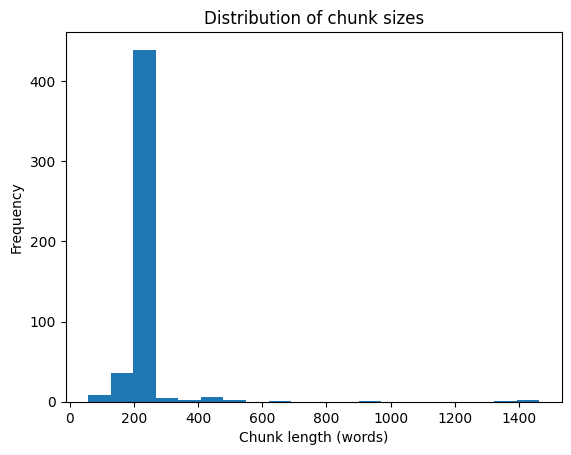

In [20]:
# Cell 5: Visualize chunk lengths

chunk_lengths = [len(ck.split()) for ck in chunks]
plt.hist(chunk_lengths, bins=20)
plt.xlabel("Chunk length (words)")
plt.ylabel("Frequency")
plt.title("Distribution of chunk sizes")
plt.show()

In [21]:
# Cell 6: Generate embeddings using our chosen model
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(chunks, show_progress_bar=True, batch_size=32, normalize_embeddings=True)
print("Embeddings shape:", embeddings.shape)

Batches: 100%|██████████| 16/16 [00:03<00:00,  4.70it/s]

Embeddings shape: (504, 384)


In [22]:
# Cell 7: Save chunks, and build/save FAISS vector DB for our pipeline

chunks_dir = "../chunks"
vectordb_dir = "../vectordb"
if not os.path.exists(chunks_dir):
    os.makedirs(chunks_dir)
if not os.path.exists(vectordb_dir):
    os.makedirs(vectordb_dir)

# Save chunks as metadata
np.save(os.path.join(vectordb_dir, "chunk_metadata.npy"), np.array(chunks))
# Build and save FAISS index
dim = embeddings.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(embeddings)
faiss.write_index(index, os.path.join(vectordb_dir, "faiss.index"))

print(f"Saved {len(chunks)} chunks and FAISS index to {vectordb_dir}.")

Saved 504 chunks and FAISS index to ../vectordb.
